# Baseline model:
This notebook contains our baseline model without feature engineering. We will test out  3 different classification models on our data set to see which performs best. We will then perform feature selection and hyperparameter tuning.

## Needed libraries:

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
# data frame and visualization libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

warnings.filterwarnings("ignore")

#  scaling module
from sklearn.preprocessing import StandardScaler

# validation and split libraries
from sklearn.model_selection import train_test_split


# Statistical model libraries
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Functions we will use

In [49]:
def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    train = roc_auc_score(y_train, train_prob)
    val = roc_auc_score(y_val, val_prob)
    print("train:", round(train, 2), "test:", round(val, 2))

In [4]:
def annot(fpr, tpr, thr):
    k = 0
    for i, j in zip(fpr, tpr):
        if k % 50 == 0:
            plt.annotate(round(thr[k], 2), xy=(i, j), textcoords="data")
        k += 1

In [51]:
def roc_plot(model, X_train, y_train, X_val, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    plt.figure(figsize=(7, 7))
    for data in [[y_train, train_prob], [y_val, val_prob]]:  # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.ylabel("TPR (power)")
    plt.xlabel("FPR (alpha)")
    plt.legend(["train", "test"])
    plt.show()

In [6]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [
        col
        for col in opt.columns
        if ("mean" in col or "std" in col) and "time" not in col
    ]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)

    plt.figure(figsize=[15, 4])
    plt.subplot(121)
    sns.heatmap(
        pd.pivot_table(
            opt,
            index="max_depth",
            columns="min_samples_leaf",
            values="mean_train_score",
        )
        * 100
    )
    plt.title("ROC_AUC - Training")
    plt.subplot(122)
    sns.heatmap(
        pd.pivot_table(
            opt, index="max_depth", columns="min_samples_leaf", values="mean_test_score"
        )
        * 100
    )
    plt.title("ROC_AUC - Validation")


#     return opt

## Load the Data:

In [7]:
baseline_df = pd.read_csv("../data/telecom_cleaned.csv")

In [8]:
print("-----------------------------------------")
print("The Dataframe has:", baseline_df.shape[1], "columns")
print("The Dataframe has:", baseline_df.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
The Dataframe has: 22 columns
The Dataframe has: 3333 rows
-----------------------------------------


In [9]:
list(baseline_df.columns)

['Unnamed: 0',
 'state',
 'account_length',
 'area_code',
 'phone_number',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn',
 'international_plan_yes',
 'voice_mail_plan_yes']

## Create Train/Test/Split and Validation sets

In [10]:
# feature selection
X = baseline_df.drop(
    ["Unnamed: 0", "churn", "state", "phone_number", "area_code", "account_length"],
    axis=1,
)
y = baseline_df.loc[:, ["churn"]]

In [11]:
print("-----------------------------------------")
print("X has:", X.shape[1], "columns")
print("X has:", X.shape[0], "rows")
print("-----------------------------------------")
print("Y has:", y.shape[1], "columns")
print("Y has:", y.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
X has: 16 columns
X has: 3333 rows
-----------------------------------------
Y has: 1 columns
Y has: 3333 rows
-----------------------------------------


In [12]:
# Create our train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Create our validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [13]:
print("------------------------------------------------")
print("The X and Y Train shape is:", X_train.shape, y_train.shape)
print("The X and Y Val shape is:", X_val.shape, y_val.shape)
print("The X and Y Test shape is:", X_test.shape, y_test.shape)
print("Totals :", X_train.shape[0] + X_val.shape[0] + X_test.shape[0], "Rows")
print("------------------------------------------------")

------------------------------------------------
The X and Y Train shape is: (2132, 16) (2132, 1)
The X and Y Val shape is: (534, 16) (534, 1)
The X and Y Test shape is: (667, 16) (667, 1)
Totals : 3333 Rows
------------------------------------------------


In [14]:
baseline_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

## Baseline model Decision tree

In [16]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=140)

In [17]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

train: 0.74 Validation_test: 0.71


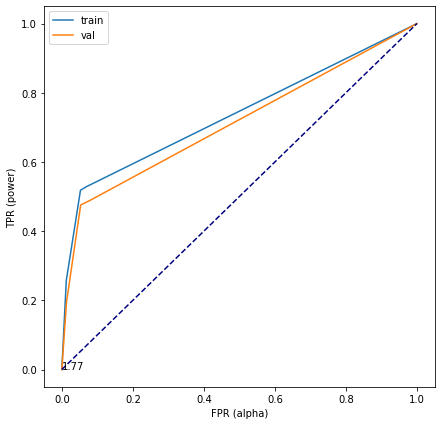

In [19]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

In [20]:
dot_data = StringIO()

export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

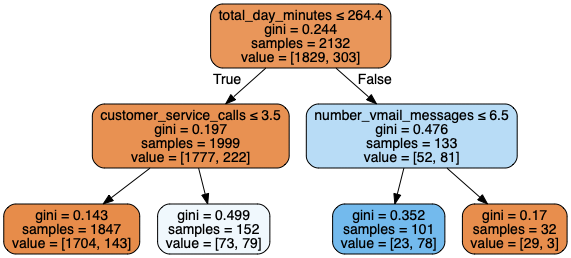

In [21]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value = [notchurn, churn]

### Metrics of evaluation:

# Tuned models:

## Decision Tree

In [22]:
# manual tweaks
tree_clf = DecisionTreeClassifier(
    min_samples_leaf=5, max_depth=4, class_weight="balanced", random_state=140
)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

train: 0.9 Validation_test: 0.89


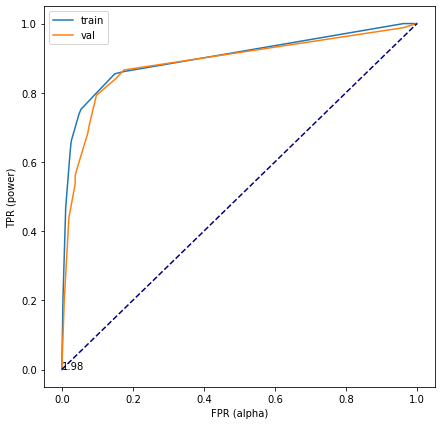

In [23]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

In [24]:
dot_data = StringIO()

In [25]:
export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

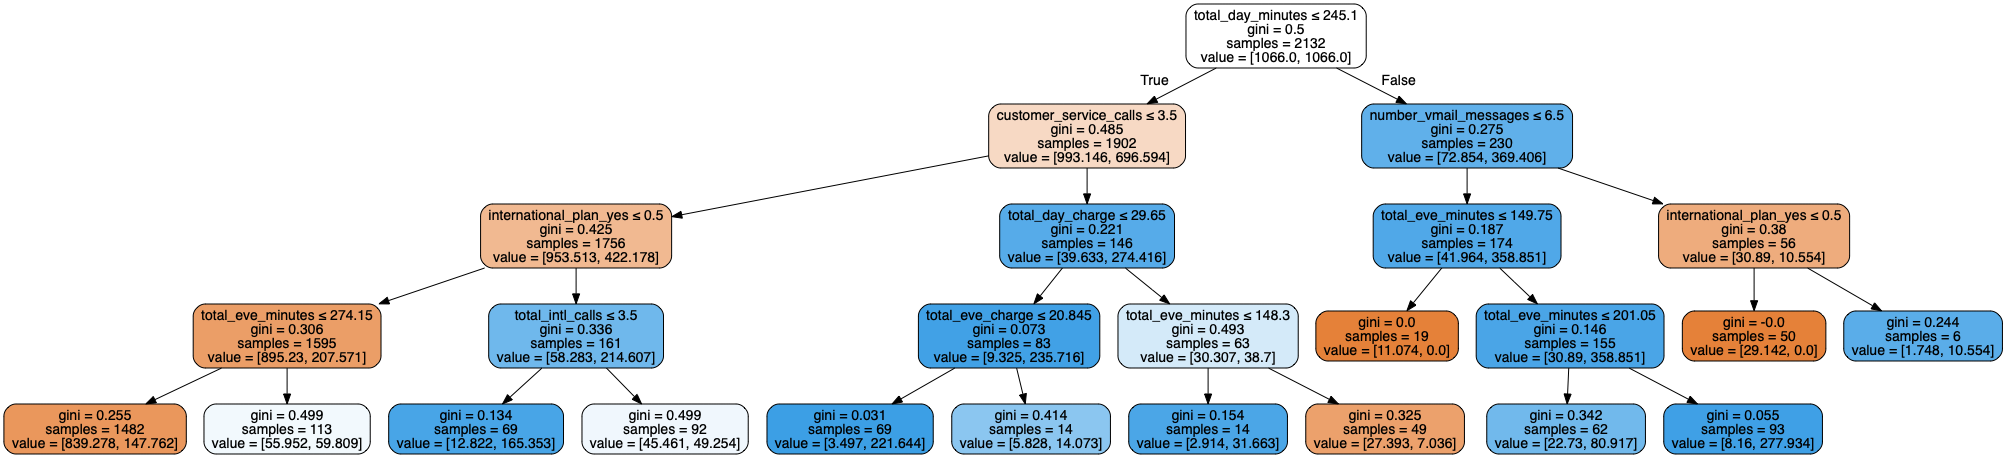

In [26]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value= [notchurn, churn]

## Grid search with the decision tree

In [27]:
skf = StratifiedKFold(n_splits=5, random_state=140)

### Start with a wide net:

train: 0.94 Validation_test: 0.9
{'max_depth': 15, 'min_samples_leaf': 50}
CPU times: user 2.44 s, sys: 53.9 ms, total: 2.5 s
Wall time: 3.1 s


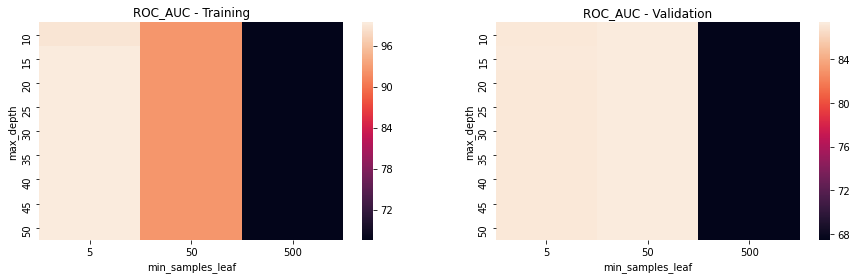

In [28]:
%%time
param_grid = {'max_depth':range(10,51, 5), 'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

narrow down the net maybe to 50 min sample lead range

### 50 min sample leaf 10-15 depth

train: 0.93 Validation_test: 0.9
{'max_depth': 11, 'min_samples_leaf': 51}
CPU times: user 1.62 s, sys: 29.5 ms, total: 1.65 s
Wall time: 2.26 s


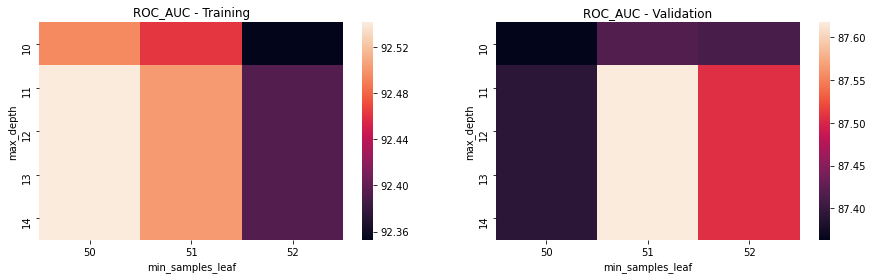

In [29]:
%%time
param_grid = {'max_depth':range(10,15), 'min_samples_leaf':range(50,53)}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

In [30]:
### decrease sample leaf

train: 0.94 Validation_test: 0.9
{'max_depth': 11, 'min_samples_leaf': 47}
CPU times: user 981 ms, sys: 18 ms, total: 999 ms
Wall time: 1.19 s


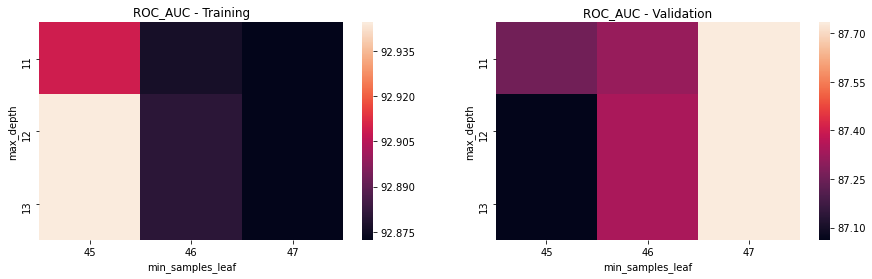

In [31]:
%%time
param_grid = {'max_depth':range(11,14), 'min_samples_leaf':range(45,48)}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.94 Validation_test: 0.9


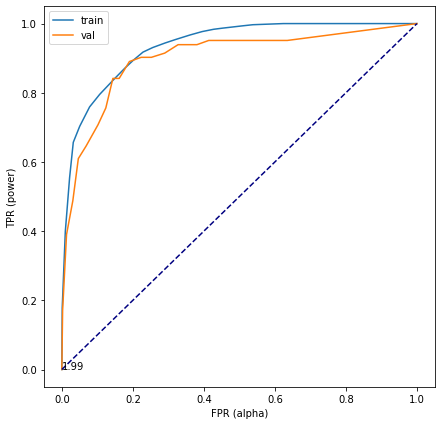

In [32]:
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(d_tree_best_model, X_train, y_train, X_val, y_val)

### Narrowed down to:

train: 0.92 Validation_test: 0.88
{'max_depth': 6, 'min_samples_leaf': 34}
CPU times: user 1.2 s, sys: 27.7 ms, total: 1.23 s
Wall time: 1.67 s


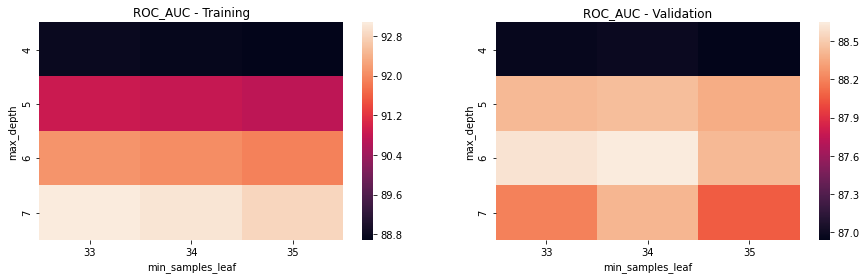

In [33]:
%%time
param_grid = {'max_depth':range(4,8), 'min_samples_leaf':range(33,36)}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.92 Validation_test: 0.88


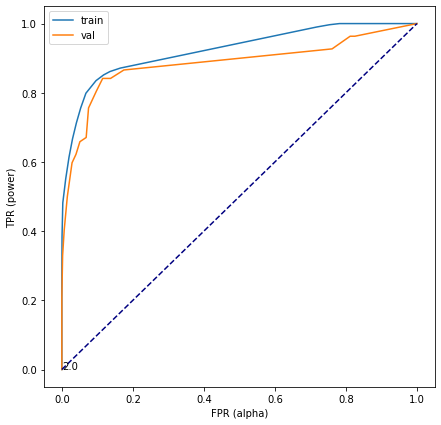

In [34]:
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(d_tree_best_model, X_train, y_train, X_val, y_val)

we like this model best

## K nearest neighbours

In [35]:
knn_clf = KNeighborsClassifier(n_neighbors=19, metric="manhattan")
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

train: 0.81 Validation_test: 0.78


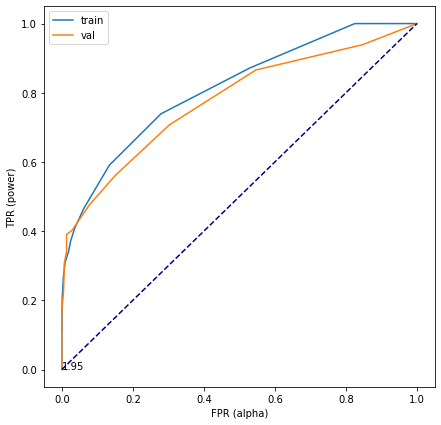

In [36]:
scores(knn_clf, X_train, X_val, y_train, y_val)
roc_plot(knn_clf, X_train, y_train, X_val, y_val)

## K nearest neighbors grid search

In [37]:
%%time
grid_params = {
    "n_neighbors": [3, 5, 11, 19],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

opt_model = GridSearchCV(knn_clf, grid_params, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
knn_best_model = opt_model.best_estimator_

scores(knn_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)

train: 1.0 Validation_test: 0.79
{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
CPU times: user 5.09 s, sys: 67.7 ms, total: 5.16 s
Wall time: 6.71 s


train: 1.0 Validation_test: 0.79


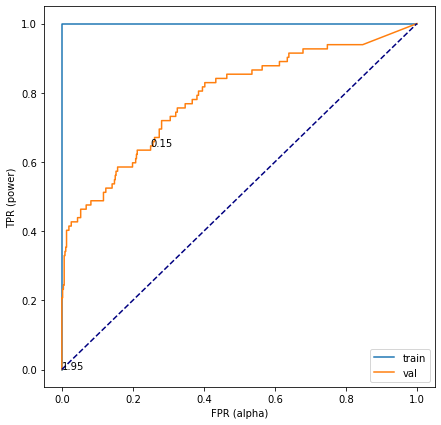

In [38]:
scores(knn_best_model, X_train, X_val, y_train, y_val)
roc_plot(knn_best_model, X_train, y_train, X_val, y_val)

## Random Forrest

In [39]:
rndf_clf = RandomForestClassifier(n_estimators=100, random_state=140)
rndf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=140,
                       verbose=0, warm_start=False)

### Grid search random Forrest

### broad hyper params

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.990, test=0.866), total=   0.4s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.887), total=   0.7s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.903), total=   0.6s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.986, test=0.948), total=   0.7s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.987, test=0.949), total=   0.5s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.988, test=0.865), total=   0.7s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.985, test=0.883), total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.986, test=0.907), total=   0.7s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.983, test=0.950), total=   0.5s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.984, test=0.939), total=   0.5s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.987, test=0.869), total=   0.6s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.983, test=0.884), total=   0.5s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.984, test=0.899), total=   0.5s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.981, test=0.945), total=   0.6s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.982, test=0.947), total=   0.5s
[CV] max_depth=10, min_samples_leaf=8 ................................
[CV]  max_depth=10, min_samples_leaf=8, score=(train

[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:  2.0min finished


train: 0.99 Validation_test: 0.94
{'max_depth': 12, 'min_samples_leaf': 5}
CPU times: user 1min 31s, sys: 1.62 s, total: 1min 32s
Wall time: 2min 2s


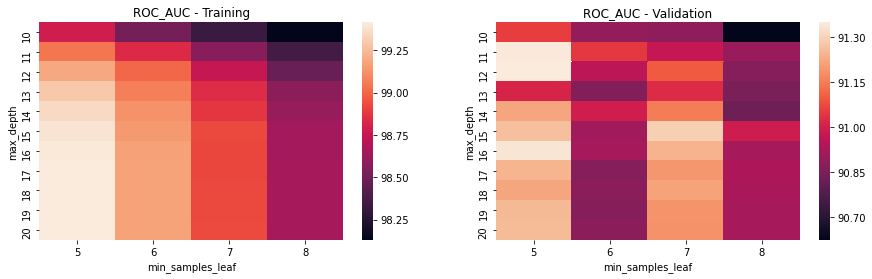

In [40]:
%%time
param_grid = {'max_depth':range(10,21),'min_samples_leaf':[5,6,7,8]}

opt_model = GridSearchCV(rndf_clf,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,verbose=10)
opt_model.fit(X_train,y_train)
rndf_best_model = opt_model.best_estimator_

scores(rndf_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 Validation_test: 0.94


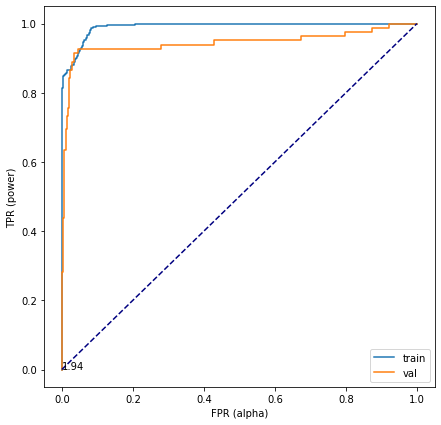

In [41]:
scores(rndf_best_model, X_train, X_val, y_train, y_val)
roc_plot(rndf_best_model, X_train, y_train, X_val, y_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.990, test=0.866), total=   0.7s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.887), total=   0.7s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.903), total=   0.5s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.986, test=0.948), total=   0.5s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.987, test=0.949), total=   0.5s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.988, test=0.865), total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.985, test=0.883), total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.986, test=0.907), total=   0.5s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.983, test=0.950), total=   0.7s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.1s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.984, test=0.939), total=   0.9s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=5, score=(train=0.992, test=0.867), total=   0.5s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=5, score=(train=0.991, test=0.888), total=   0.6s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=5, score=(train=0.991, test=0.914), total=   0.5s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=5, score=(train=0.989, test=0.950), total=   0.4s
[CV] max_depth=11, min_samples_leaf=5 ................................
[CV]  max_depth=11, min_samples_leaf=5, score=(train=0.989, test=0.948), total=   0.6s
[CV] max_depth=11, min_samples_leaf=6 ................................
[CV]  max_depth=11, min_samples_leaf=6, score=(train

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.4s finished


train: 0.99 Validation_test: 0.94
{'max_depth': 12, 'min_samples_leaf': 5}
CPU times: user 21.8 s, sys: 416 ms, total: 22.3 s
Wall time: 30.2 s


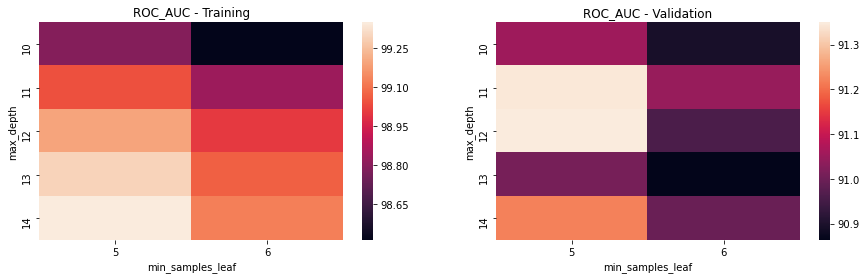

In [42]:
%%time
param_grid = {'max_depth':range(10,15),'min_samples_leaf':[5,6]}

opt_model = GridSearchCV(rndf_clf,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,verbose=10)
opt_model.fit(X_train,y_train)
rndf_best_model = opt_model.best_estimator_

scores(rndf_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

The model is too overfit even with the hyper parameter optimization, we won't use it.

## Logistic Regression (soledad's)

In [43]:
# Scale the set
# ss = StandardScaler()

# ss.fit(X_train)

# X_train_v = ss.transform(X_train)
# X_val = ss.transform(X_val)

In [44]:
l_reg = LogisticRegression(
    fit_intercept=True, C=1e12, solver="liblinear", random_state=42
)
l_reg.fit(X_train, y_train)
l_reg

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Param tuning

In [45]:
param_grid = {"C": [1, 10, 100, 1000]}

l_reg_opt_model = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=10000, penalty="l2"),
    param_grid,
    cv=skf,
    scoring="roc_auc",
    return_train_score=True,
)

l_reg_opt_model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=140, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

train: 0.83 Validation_test: 0.84


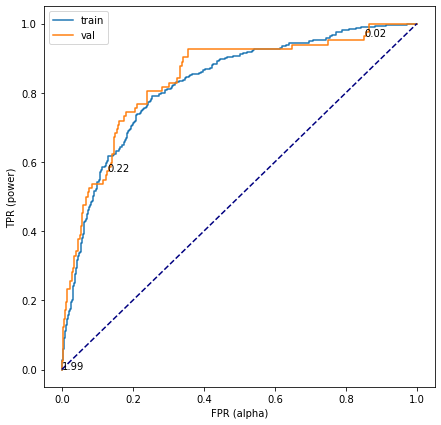

In [46]:
scores(l_reg_opt_model, X_train, X_val, y_train, y_val)
roc_plot(l_reg_opt_model, X_train, y_train, X_val, y_val)

# Chosen model (Decision Tree)

In [61]:
probs_val = d_tree_best_model.predict_proba(X_val)
probs_val[:, 1]

array([0.        , 0.17677191, 0.        , 0.17677191, 1.        ,
       0.17677191, 0.17677191, 0.43626562, 0.17677191, 1.        ,
       0.17677191, 0.99641153, 0.17677191, 0.25466444, 0.25466444,
       0.17677191, 0.17677191, 0.17677191, 0.17677191, 0.        ,
       0.89418913, 0.8429057 , 0.17677191, 0.17677191, 0.17677191,
       0.17677191, 0.17677191, 0.43626562, 0.        , 0.17677191,
       0.17677191, 0.        , 0.17677191, 0.80862755, 1.        ,
       0.17677191, 0.        , 0.17677191, 0.        , 0.25466444,
       0.17677191, 0.17677191, 0.74400776, 0.43626562, 0.78103341,
       0.17677191, 0.99641153, 0.17677191, 0.        , 0.17677191,
       0.35432003, 0.17677191, 0.17677191, 0.17677191, 0.17677191,
       0.74400776, 0.17677191, 0.17677191, 0.35432003, 0.25466444,
       0.89418913, 0.        , 0.17677191, 0.        , 0.17677191,
       0.        , 0.17677191, 0.10583266, 0.10583266, 0.17677191,
       0.17677191, 0.17677191, 0.80862755, 1.        , 0.25466

In [58]:
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, probs_val[:, 1])

In [81]:
# Training and test set positive probabilities
probs_train = d_tree_best_model.predict_proba(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probs_train[:, 1])

probs_test = d_tree_best_model.predict_proba(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test[:, 1])

## The validation Test:

train: 0.92 test: 0.88


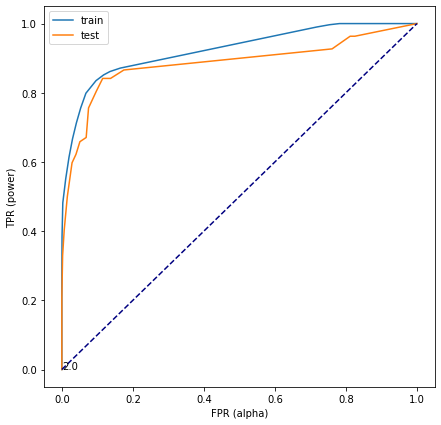

In [82]:
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(d_tree_best_model, X_train, y_train, X_val, y_val)

## The big test:

train: 0.92 test: 0.85


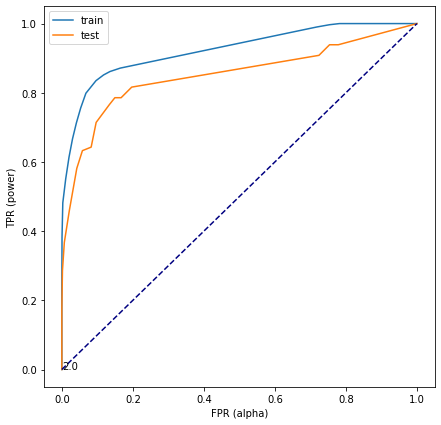

In [83]:
scores(d_tree_best_model, X_train, X_test, y_train, y_test)
roc_plot(d_tree_best_model, X_train, y_train, X_test, y_test)

### Feature interpretation

In [54]:
#Feature importances:

for name, score in zip(X_train.columns, d_tree_best_model.feature_importances_):

    print(name, score)

number_vmail_messages 0.0
total_day_minutes 0.22200267404146662
total_day_calls 0.0015380972809331296
total_day_charge 0.07220152828341597
total_eve_minutes 0.064251637842232
total_eve_calls 0.0
total_eve_charge 0.0
total_night_minutes 0.017108074062141092
total_night_calls 0.005360719629952077
total_night_charge 0.0
total_intl_minutes 0.0
total_intl_calls 0.038211531210311026
total_intl_charge 0.0275670301997037
customer_service_calls 0.25780429997375753
international_plan_yes 0.2455911918541847
voice_mail_plan_yes 0.04836321562190224


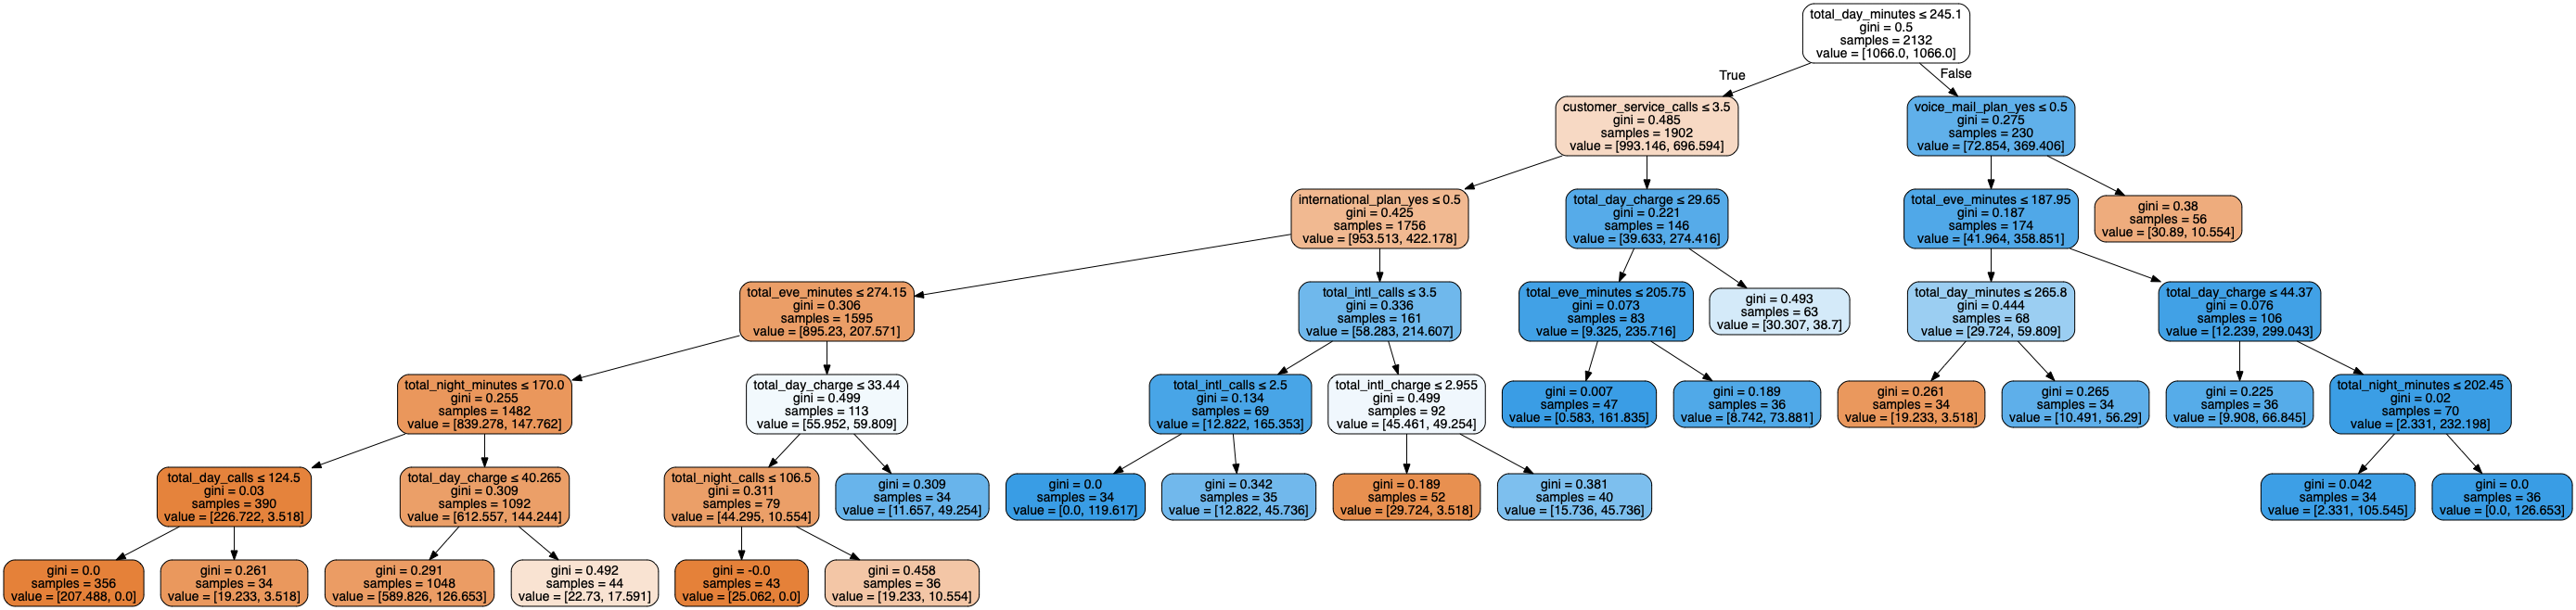

In [108]:
dot_data = StringIO()

export_graphviz(
    d_tree_best_model,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value= [notchurn, churn]

We decided to choose the decision tree as it was our highest performer on our validation set. Although random forrest performed higher it was quite overfit.

## Threshold Selection

### Prevalance

source: http://www.dbmarketing.com/telecom/churnreduction.html <br>
it can cost 50 times less to keep an existing customer than to aquire a new one according to : https://telecoms.com/opinion/churn-is-breaking-the-telecoms-market-heres-how-to-fix-it/

The industry average for churn rate is around 1.9-2.1 percent per month (10-67% per year) we will go with the prevalence of our dataset

In [66]:
# select prevalence based on research:
prevalence = y["churn"].value_counts()[1] / y["churn"].value_counts()[0]
prevalence

0.1694736842105263

### cost of FP, TN, FN, and TP

In [68]:
# According to our source, it costs 50 times less to keep an existing customer than it does to acquire a new one
# A false positive would indicate that we wrongfully predicted that a customer would churn when they actually wouldn't have
# According to candian telecom data that retention cost can be  C$11.74
FPc = 11.74
# The cost of a True negative or predicting that there truly would not be a customer churn when there really wasn't would not cost us anything.
TNc = 0
# The cost of a False negative or a falsely saying that a customer wouldn't churn when they actually would is quite high.
# This cost is 50 times higher than our False positive according to our source
FNc = 11.74 * 50
# The cost of our True positive, or correctly predicting a churn when our customer actually would have churned would be the same price as our false positive
TPc = 11.74

# References:
# http://www.dbmarketing.com/telecom/churnreduction.html
# https://telecoms.com/opinion/churn-is-breaking-the-telecoms-market-heres-how-to-fix-it/
# https://www.commsmea.com/11306-customer-acquisition

### Metz parameter:

In [69]:
m = (1 - prevalence) / prevalence * (FPc - TNc) / (FNc - TPc)
m

0.10001267587780455

### Calculate FM

In [84]:
fm_list = tpr_test - (m * fpr_test)
list(zip(fm_list.tolist(), thresholds_test.tolist()))

[(0.0, 2.0),
 (0.17346938775510204, 1.0),
 (0.2855385165123915, 0.9964115257529282),
 (0.3666438619679334, 0.9783887878463678),
 (0.4570744430466573, 0.8941891325604134),
 (0.5072160052004515, 0.8709087263796301),
 (0.5774141922157635, 0.8429056973327957),
 (0.6268526775619809, 0.8086275500536854),
 (0.6345959903681151, 0.7810334066944782),
 (0.7046184081815329, 0.7440077601852432),
 (0.7519476631050197, 0.5608083623693381),
 (0.770773903553278, 0.43626562350920717),
 (0.7690162115343359, 0.3543200309957381),
 (0.7966403800000936, 0.2546644388749652),
 (0.8357463541257086, 0.17677190721649155),
 (0.8633705225914663, 0.1546330740615489),
 (0.8609097537649474, 0.10583265825714618),
 (0.8999873241221954, 0.0)]

highest fm score is 0.8999873241221954 and it corresponds to a threshold of 0

### Confusion matrix:

In [114]:
probs_list = probs_test[:, 1].tolist()

my_results = []
for x in probs_list:
    if x > 0:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

confusion = []
for i, real in enumerate(y_test["churn"].tolist()):
    if my_results[i] == real:
        if my_results[i] == 0:
            confusion.append("TN")
        else:
            confusion.append("TP")
    else:
        if my_results[i] == 0:
            confusion.append("FN")
        else:
            confusion.append("FP")

pd.Series(confusion).value_counts()

FP    443
TN    126
TP     92
FN      6
dtype: int64

### Our models monetary costs:

In [130]:
print(
    "The cost of our model thinking there is a possible churn when there actually isn't:",
    443 * FPc,
)
print(
    "The cost our model makes when it accurately predicts a churned customer:",
    92 * TPc,
)
print(
    "The business cost of not implementing our model:", 92 * FNc,
)
print("The cost of our models mistake of not detecting a churned customer:", FNc * 6)

The cost of our model thinking there is a possible churn when there actually isn't: 5200.82
The cost our model makes when it accurately predicts a churned customer: 1080.08
The business cost of not implementing our model: 54004.0
The cost of our models mistake of not detecting a churned customer: 3522.0


### Calculate alpha/power/precision/accuracy

In [107]:
y_predic = d_tree_best_model.predict(X_test)

In [118]:
# Model Evaluation metrics
alpha = 443 / (126 + 443)
print("Alpha : " + str(alpha))
power = 92 / (6 + 92)
print("Power : " + str(power))
print("Accuracy Score : " + str(accuracy_score(y_test, y_predic)))
print("Precision Score : " + str(precision_score(y_test, y_predic)))
print("Recall Score : " + str(recall_score(y_test, y_predic)))
print("F1 Score : " + str(f1_score(y_test, y_predic)))

Alpha : 0.7785588752196837
Power : 0.9387755102040817
Accuracy Score : 0.8515742128935532
Precision Score : 0.4966887417218543
Recall Score : 0.7653061224489796
F1 Score : 0.6024096385542169


### Stakeholder interpretation

* Alpha - There is a 27% chance that our model will say that a customer will churn when they actually wont.
* Power - There is a 7% chance that our model will say that a customer will not churn when they actually will.
* Precision - Of the recalled churners,  our model will get 49% of them right
* Accuracy - Of the 76% recalled it will accurately state there is a potential churn 85% of the time.
* Recall Score - The model will recall 76% of potential churners 

## Actionable plan for stakeholders:

Focus on customer service this is a big driving decision for consumer churn rates. The happier our costumers feel during this time the more likely they are to stay loyal. 